In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa

# 双门限法

In [2]:
def endpoint_detection(
        file_path, frame_len=400, step=160, 
        ITL=0.3, ITU=0.2, ZCR_th=50, min_silence=10
):
    # 读取音频
    y, sr = sf.read(file_path)
    if y.ndim > 1: y = y[:,0]  # 转为单声道
    
    # 预加重
    y = np.append(y[0], y[1:] - 0.97 * y[:-1])
    
    # 分帧
    frames = []
    n_frames = (len(y) - frame_len) // step + 1
    for i in range(n_frames):
        frames.append(y[i*step : i*step+frame_len])
    
    # 计算短时能量和过零率
    energy = np.array([np.sum(frame**2) for frame in frames])
    zcr = np.array([0.5 * np.sum(np.abs(np.diff(np.sign(frame)))) for frame in frames])
    
    # 归一化
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    
    # 端点检测
    in_speech = False
    speech_segments = []
    silence_count = 0
    start = 0
    
    for i in range(len(energy)):
        if not in_speech:
            if energy[i] > ITL or zcr[i] > ZCR_th:
                start = max(0, i - 2)
                in_speech = True
        else:
            if energy[i] < ITU and zcr[i] < ZCR_th:
                silence_count += 1
                if silence_count >= min_silence:
                    end = i - silence_count
                    speech_segments.append((start*step, end*step))
                    in_speech = False
                    silence_count = 0
            else:
                silence_count = 0
    
    return speech_segments, y, energy, zcr

In [3]:
# 可视化结果
def plot(wav_path):
    segments, y, energy, zcr = endpoint_detection(wav_path)

    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.plot(y)
    for seg in segments:
        plt.axvspan(seg[0], seg[1], color='red', alpha=0.3)
    plt.title("Waveform with Speech Segments")
    
    plt.subplot(212)
    plt.plot(energy, label='Energy')
    plt.plot(zcr/np.max(zcr), label='ZCR (normalized)')
    plt.legend()
    plt.show()

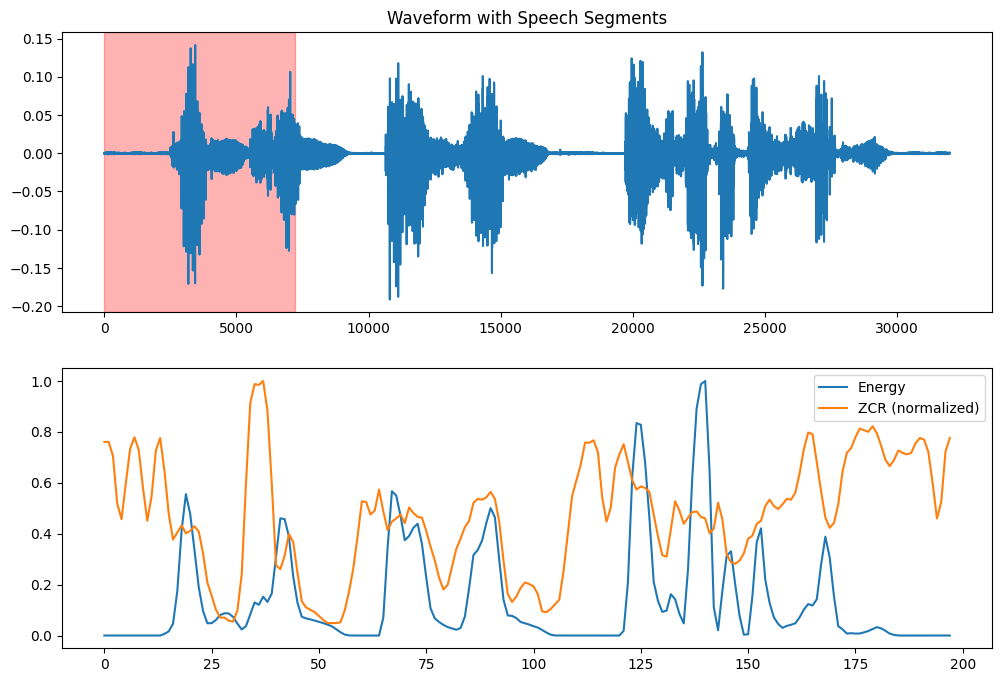

In [4]:
# 测试代码
plot("C4_1_y.wav")

# 基本谱减法

In [5]:
def add_noise(clean, snr):
    noise = np.random.randn(len(clean))
    clean_power = np.mean(clean**2)
    noise_power = np.mean(noise**2)
    scale = np.sqrt(clean_power / (10**(snr/10) * noise_power))
    return clean + noise * scale

def spectral_subtraction(noisy, sr, n_fft=512, hop_length=160, win_length=400, noise_frames=5):
    # 计算STFT
    D = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length, 
                    win_length=win_length, window='hann')
    mag = np.abs(D)
    
    # 估计噪声谱
    noise_profile = np.mean(mag[:, :noise_frames], axis=1, keepdims=True)
    
    # 谱减法
    mag_enhanced = np.maximum(mag - noise_profile, 0)
    
    # 重建信号
    D_enhanced = mag_enhanced * np.exp(1j * np.angle(D))
    enhanced = librosa.istft(D_enhanced, hop_length=hop_length, 
                            win_length=win_length, window='hann')
    
    return enhanced

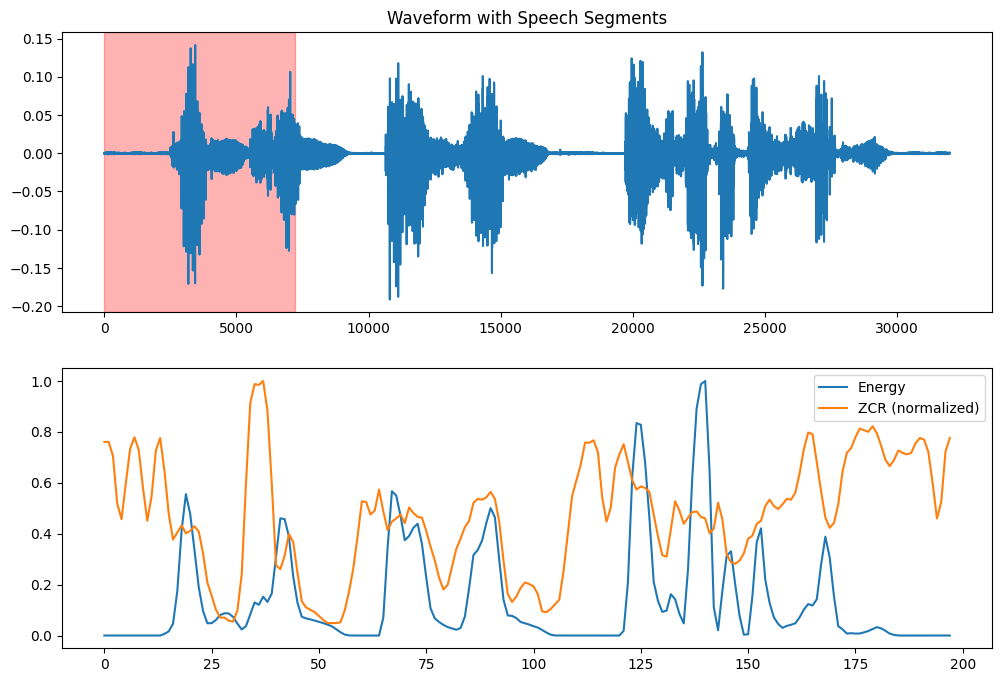

In [6]:
# 测试代码
clean, sr = sf.read("C6_1_y.wav")
plot("C6_1_y.wav")

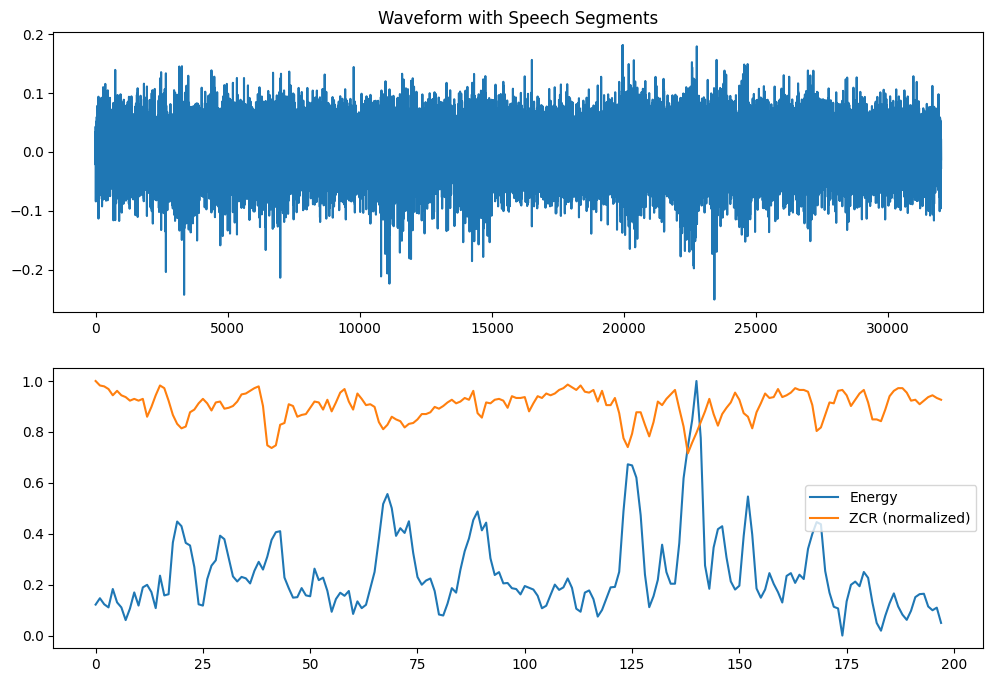

In [7]:
noisy = add_noise(clean, snr=5)
sf.write('noise1.wav', noisy, sr)
plot('noise1.wav')

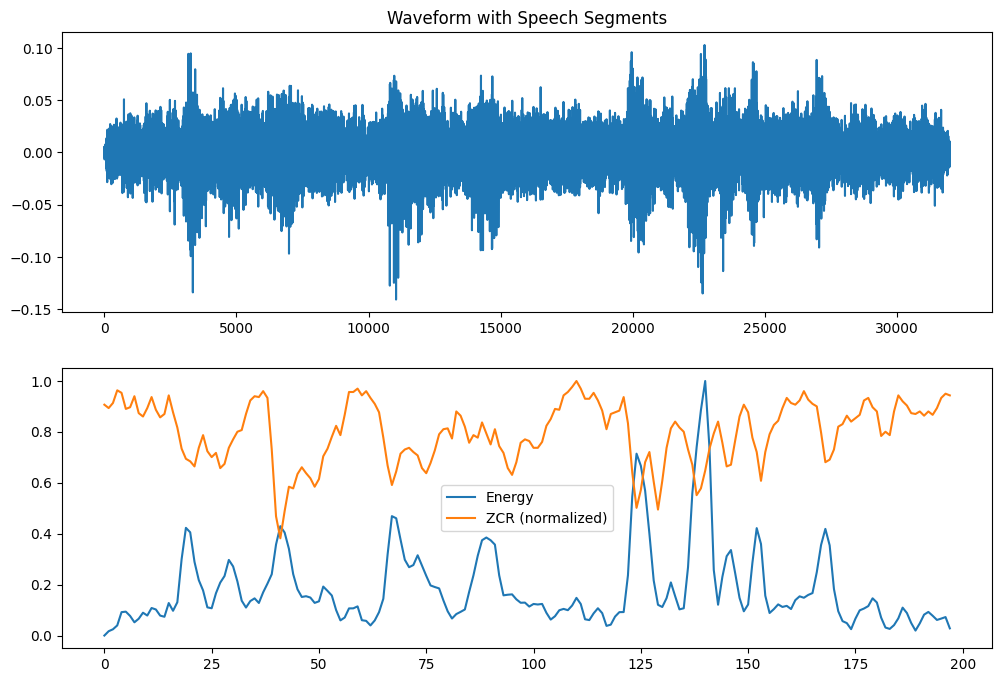

In [8]:
enhanced = spectral_subtraction(noisy, sr)
sf.write('enhanced_ss_fixed.wav', enhanced, sr)
plot('enhanced_ss_fixed.wav')

# 基本维纳滤波法

In [9]:
def wiener_filter(noisy, sr, n_fft=512, hop_length=160, win_length=400, noise_frames=5):
    # 计算STFT
    D = librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length,
                    win_length=win_length, window='hann')
    power = np.abs(D)**2
    
    # 估计噪声功率
    noise_power = np.mean(power[:, :noise_frames], axis=1, keepdims=True)
    
    # 维纳滤波
    snr_prior = np.maximum((power - noise_power) / noise_power, 1e-6)
    H = snr_prior / (1 + snr_prior)
    
    # 应用滤波
    D_enhanced = D * H
    enhanced = librosa.istft(D_enhanced, hop_length=hop_length,
                           win_length=win_length, window='hann')
    
    return enhanced

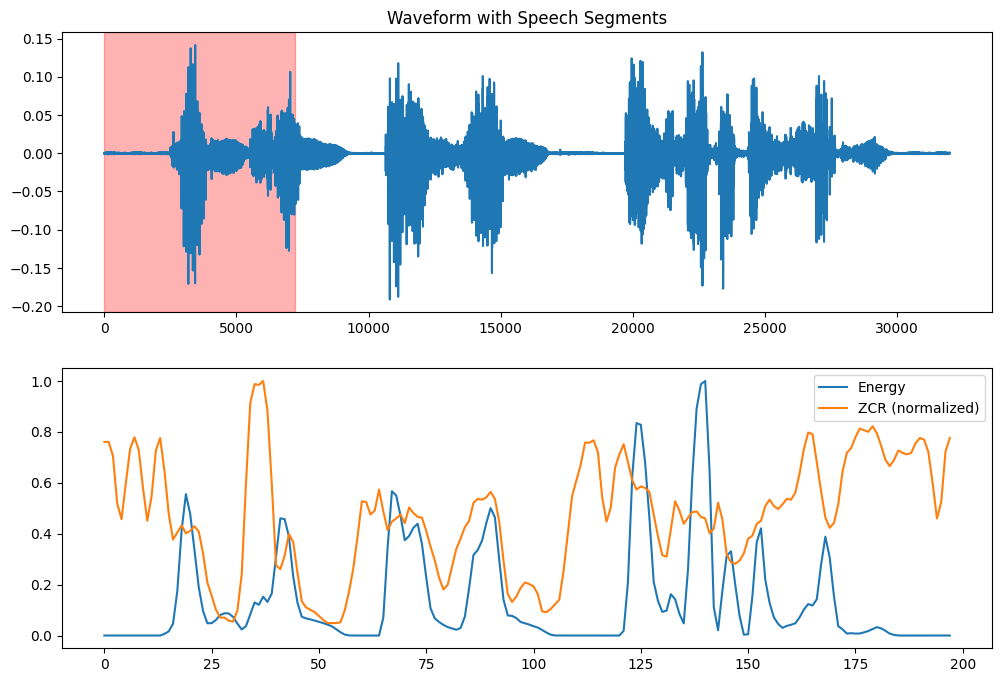

In [10]:
# 测试代码
clean, sr = sf.read("C6_2_y.wav")
plot("C6_2_y.wav")

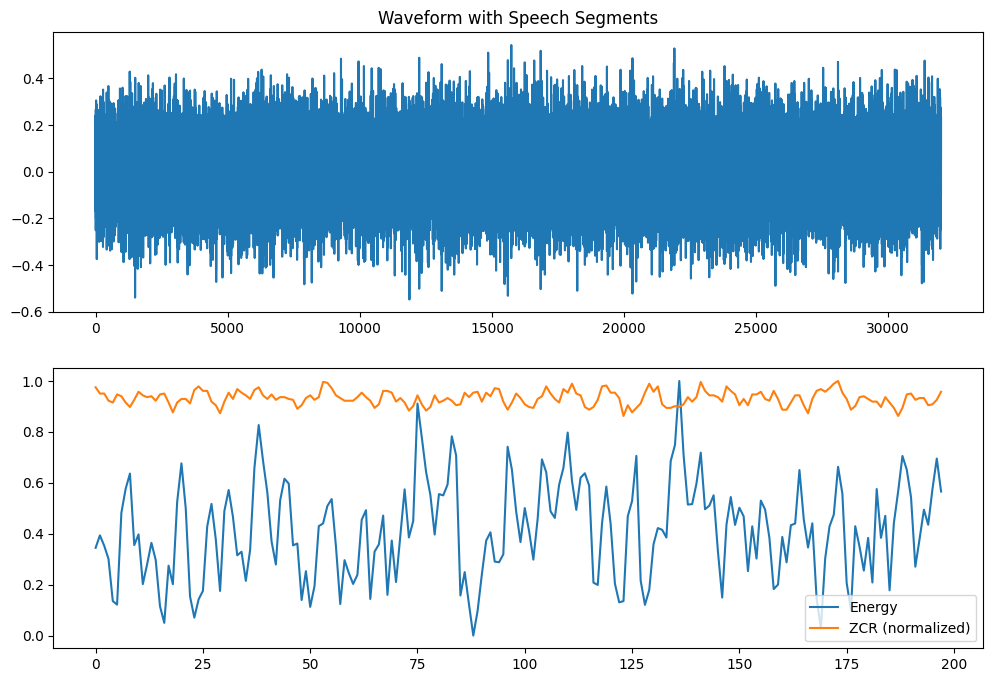

In [11]:
noise = np.random.randn(len(clean)) * 0.1
noisy = clean + noise
sf.write('noise2.wav', noisy, sr)
plot('noise2.wav')

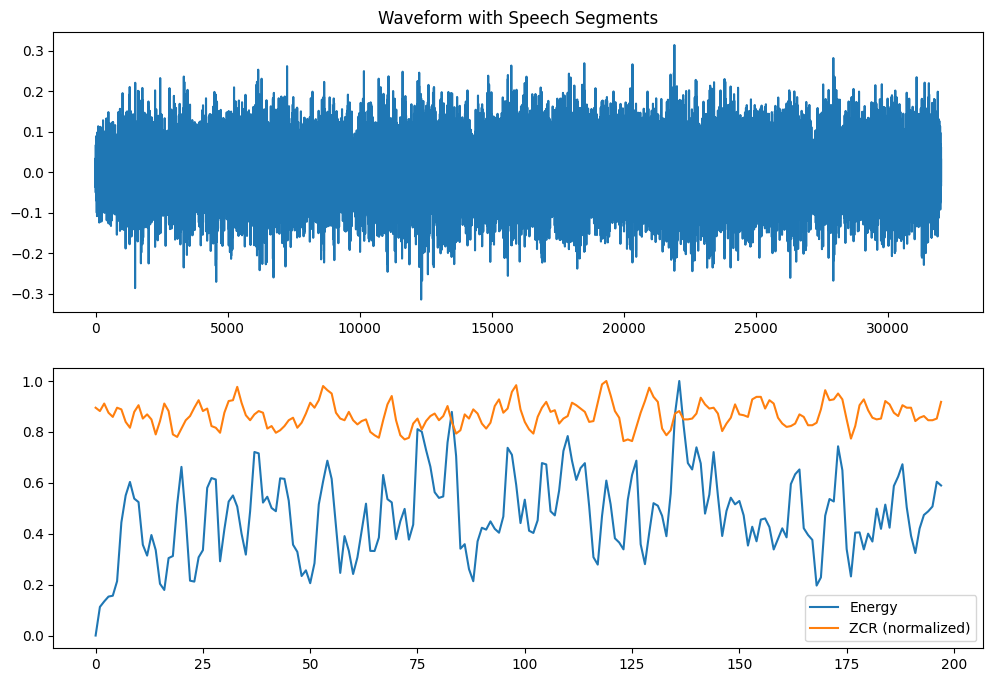

In [12]:
enhanced = wiener_filter(noisy, sr)
sf.write('enhanced_wiener_fixed.wav', enhanced, sr)
plot('enhanced_wiener_fixed.wav')